In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import gym
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import HTML, clear_output
%matplotlib inline

from utils import show_video, dynamic_gpu_usage, play_in_video, evaluate, moving_average
from wrappers import ActionMapWrapper, BWrapper, MaxStepsWrapper, StackedLagWrapper, FrameSkipper
from QLearningAgent import QLearningAgent

dynamic_gpu_usage()

Tensorflow version: 1.14.0
1 Physical GPUs, 1 Logical GPUs


In [3]:
env_name = 'CarRacing-v0'
recordings = 'recordings/carracing-qlearning1'
env = MaxStepsWrapper(FrameSkipper(gym.make(env_name, verbose=False), 50, [0,0,0]), 10000)

play_in_video(env, recordings + "/0")

Total reward: -42.204968944100145


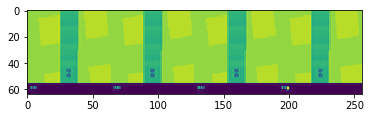

In [4]:
IMAGE_SIZE = (64, 64)

action_map = [
    [0,0,0], # Nothing
    [0,1,0], # Full gas
    [0,0,1], # Full break
    [-1,0,0], # Full left
    [1,0,0], # Full right
]  

train_env = StackedLagWrapper(BWrapper(ActionMapWrapper(FrameSkipper(gym.make(env_name, verbose=False), 50, [0,0,0]), action_map), IMAGE_SIZE), lag=4)

obs_shape = train_env.reset().shape
n_actions = len(action_map)

for _ in range(50):
    obs, _, _, _ = train_env.step(0)

plt.imshow(np.hstack([x for x in obs.transpose([2,0,1])]));

In [5]:
from tensorflow.keras import models, layers, backend, optimizers

q_model = models.Sequential()
q_model.add(layers.InputLayer(obs_shape))
q_model.add(layers.Conv2D(filters=16, kernel_size=3, strides=2, activation='relu'))
q_model.add(layers.Conv2D(filters=32, kernel_size=3, strides=2, activation='relu'))
q_model.add(layers.Conv2D(filters=64, kernel_size=3, strides=2, activation='relu'))
q_model.add(layers.Flatten())
q_model.add(layers.Dense(256, activation='relu'))
q_model.add(layers.Dense(n_actions))
q_model.summary()

agent = QLearningAgent(obs_shape, n_actions, model=q_model, use_target_network=True, learning_rate=0.001)

# play_in_video(train_env, recordings + "/1", agent)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 31, 16)        592       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               803072    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Tota

In [6]:
n_sessions = 1000000
n_minibaches = 1
# max_steps = 1000
exploration_rate = 0.5

memory = []
er_history = []
reward_history = []
loss_history = []
test_reward_history = [0]
session_steps_history = []

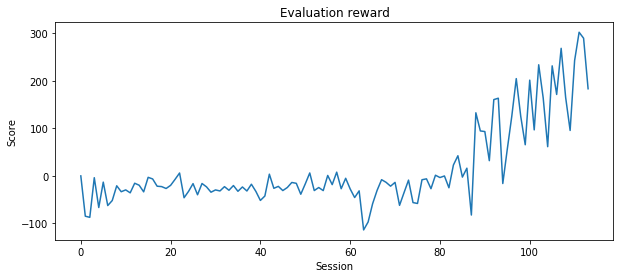

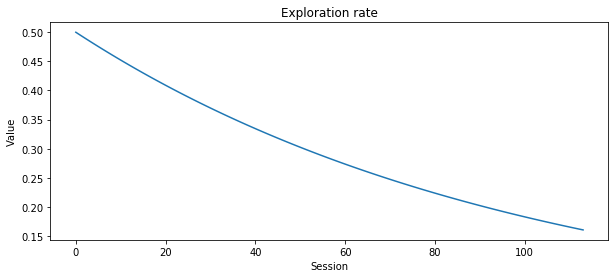

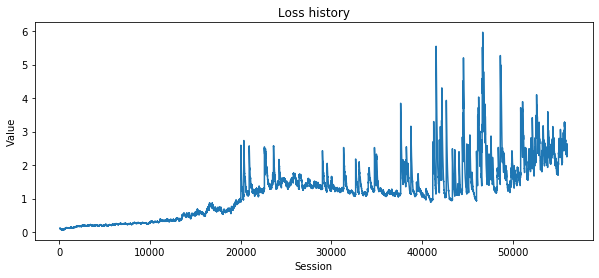

In [7]:
builder = lambda: StackedLagWrapper(BWrapper(ActionMapWrapper(FrameSkipper(gym.make(env_name, verbose=False), 50, [0,0,0]), action_map), IMAGE_SIZE), lag=4)
eval_env = builder()

er_history.append(exploration_rate)

s = train_env.reset()

for i in tqdm(range(n_sessions), total=n_sessions, desc="Sessions"):
    for _ in range(10):
        action = agent.next_action(s, exploration_rate)
        s_new, r, done, _ = train_env.step(action)
        memory.append([s, action, r, s_new, done])
        s = s_new
        if done:
            s = train_env.reset()
    
    memory = memory[-100000:]
    loss = agent.train_on_batch(*list(map(np.array, zip(*random.sample(memory, min(len(memory), 64))))))
    loss_history.append(np.mean(loss))
    
    
    if i%500 == 0:
        agent.update_target_network()
        exploration_rate = max(exploration_rate*0.99, 0.01)
        test_reward_history.append(evaluate(eval_env, agent, times=3, exploration_rate=exploration_rate))
        er_history.append(exploration_rate)
        

    if i%250 == 0:
        print("Iteration:", i)
        clear_output()
        plt.figure(figsize=(10,4))
        plt.plot(test_reward_history)
        plt.title("Evaluation reward")
        plt.ylabel("Score")
        plt.xlabel("Session")
        plt.show()

        plt.figure(figsize=(10,4))
        plt.plot(er_history)
        plt.title("Exploration rate")
        plt.ylabel("Value")
        plt.xlabel("Session")
        plt.show()
        
        plt.figure(figsize=(10,4))
        plt.plot(moving_average(loss_history, span=100, min_periods=100))
        plt.title("Loss history")
        plt.ylabel("Value")
        plt.xlabel("Session")
        plt.show()

    if np.mean(test_reward_history[-10:]) > 200:
        break

In [8]:
play_in_video(train_env, recordings + "/2", agent)

Total reward: 668.6986301369744


In [9]:
play_in_video(builder(), recordings + "/2", agent)

Total reward: 537.653061224482
